In [51]:
import numpy as np
import pandas as pd
#import numpy and pandas libraries

In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import matplotlib.pyplot as plt

#import necessary libraries in Pytorch and matplotlib

In [53]:
dataset_folder = "../../dataset/"
oil_df = pd.read_csv(dataset_folder + 'oil.csv')
coin_df = pd.read_csv(dataset_folder + 'coin.csv')
microsoft_df = pd.read_csv(dataset_folder + 'microsoft.csv')
sp500_df = pd.read_csv(dataset_folder + 'sp500.csv')
artificial1_df = pd.read_csv(dataset_folder + 'Artificial_trend.csv')
artificial2_df = pd.read_csv(dataset_folder + 'Artificial_trend1.csv')

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#we import MinMaxScaler function from sklearn to scale our dataset and also make a instance of that

In [55]:
def format_train_test (batch_size, data, percent, num_predicts, column_i):
    """
    Here is the function to make train set, test set, and label for each of them from the dataframe.We first want to see how many
    We want to find the percent of data used for train set. Then, we find length of train data so that it could divisible by batch 
    size. Then we scale the dataset and make train set and label for each by iterating through the dataset until and make them lag
    by number of predict steps we want until we have desired amount of data for train process. Then, we find the length for test
    set and we repeat the same process as forming train set and its label.

    Parameters
    ----------
    batch_size : int
        Num of batch size split
    data : DataFrame
        The dataframe that is needed
    percent : double
        Percentage split between train and test. e.g. 0.2 means 80% train and 20% test
    num_predicts : int
        Nume of predictions
    column_i : 
        The column in the data that you want to make train test set from
    """

    # prepare train data
    length_train = int(data.shape[0]*(1-percent))
    a1 = length_train//batch_size
    length_train = batch_size*a1    # get length of training
    train_data = data.iloc[:, column_i:column_i+1].values    # get desired value columns
    train_data = scaler.fit_transform(train_data)   # 0-1 scale data
    # splitting up data to train and label
    train_set = []
    train_label = []
    for i in range(length_train):
        train_set.append(train_data[i:i + num_predicts])
        train_label.append(train_data[i + num_predicts:i + 2*num_predicts])
    
    # prepare test data
    length_test = int(data.shape[0] - length_train - 4*num_predicts)
    a2 = length_test//batch_size
    length_test = int(batch_size*a2) 
    test = data.iloc[:, column_i:column_i+1].values
    test = scaler.fit_transform(test)
    test_data = test[length_train + 2*num_predicts:length_train + length_test + 4*num_predicts]
    test_set = []
    test_label = []
    for j in range(length_test):
        test_set.append(test_data[j:j + num_predicts])
        test_label.append(test_data[j + num_predicts:j + 2*num_predicts])
    
    train_set = np.reshape(np.array(train_set), (np.array(train_set).shape[0], np.array(train_set).shape[1], 1))
    train_label = np.reshape(np.array(train_label), (np.array(train_label).shape[0], np.array(train_label).shape[1],1))
    test_set = np.reshape(np.array(test_set) ,(np.array(test_set).shape[0], np.array(test_set).shape[1], 1))
    test_label = np.reshape(np.array(test_label), (np.array(test_label).shape[0], np.array(test_label).shape[1],1))
    
    return train_set, train_label, test_set, test_label, length_test


In [56]:
coin_df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [57]:
class biRNN_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2, batch_size, num_layers=2):
        super(biRNN_model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.batch_size = batch_size
        self.num_layers = num_layers

        # padding first linear layer
        # self.first_linear = nn.Linear(self.input_dim, self.input_dim)

        # two biRNN layers
        self.bi_rnn1 = nn.RNN(
                            input_size=self.input_dim,
                            hidden_size=self.hidden_dim1,
                            num_layers=self.num_layers,
                            batch_first=True,
                            bidirectional=True
                            )

        # dense layer for prediction
        self.last_linear = nn.Linear(self.hidden_dim2*2, self.output_dim)

    def forward(self, x, hidden_state):
        # s0 = self.first_linear(x)
        s1, self.hidden = self.bi_rnn1(x, hidden_state)
        return self.last_linear(s1)

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers * 2, batch_size, self.hidden_dim1).zero_()
        return hidden
        # return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1),
                # torch.zeros(self.num_layers, self.batch_size, self.hidden_dim1))

In [58]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device
# we check for the availablibility of GPU to use for training

device(type='cuda', index=0)

In [59]:
def train_test(train_tensor, test_tensor, device, batch_size, iterations, isL1Loss, learning_rate=0.001):
    model = biRNN_model(1,5,5,5,64)
    model = model.to(device)
    criterion = nn.L1Loss() if isL1Loss else nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), learning_rate)
    tr = []
    te = []
    predict = []
    values = []
    loss_name = "L1" if isL1Loss else "MSE"

    # reset parameters
    for layer in model.children():
        layer.reset_parameters()

    # loop through epochs
    for i in range(iterations):
        h0 = model.init_hidden(batch_size)    # initialize parameters
        h = h0.to(device)   # push parameters to device

        for (x,y) in train_tensor:
            x, y = x.to(device), y.to(device)
            y_hat = model(x.float(), h)
            loss = criterion(y_hat, y.float())
            optimizer.zero_grad()
            h = h.detach()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            h01 = model.init_hidden(batch_size)
            h1 = h01.to(device)
            lost_val = 0

            for (x1, y1) in test_tensor:
                x1, y1 = x1.to(device), y1.to(device)
                y_hat1 = model(x1.float(), h1)
                loss1 = criterion(y_hat1, y1.float())
                lost_val += loss1.item()
                h1 = h1.detach()
                if i == (iterations-1):
                    predict.append(y_hat1)
                    values.append(y1)
                
            lost_val /= len(x1)
            tr.append(loss.item())
            te.append(lost_val)
            print(f"Iteration {i}\n********************")
            print('The {} loss for train is: {}'.format(loss_name, loss.item()))
            print('The {} loss for test is: {}'.format(loss_name, loss.item()))
             
            for j in range(len(predict)):
                predict[j] = predict[j].cpu().numpy()
                values[j] = values[j].cpu().numpy()


    return i, tr, te, np.array(predict).reshape(-1)[::5], np.array(values).reshape(-1)
#Here we create function to do the training and validation process. We iterate through number of epochs, make initial state for model
#and iterate through each data batch to do prediction, compute the loss and do backward propagation to improve the parameters. In
#the same epoch, I also apply the model to make prediction on test dataset to keep track of model performace more closely. I also
#print iteration round, train loss, and test loss. I also return them to do some plots later.

In [60]:
def plot_predictions(predict, values, dataset_name):
    plt.figure(figsize=(14,10))
    plt.plot(predict, "-o", color="g", label="Predicted")
    plt.plot(values, color="b", label="Actual")
    plt.ylabel(dataset_name)
    plt.xlabel('Time Points')
    plt.legend()

def plot_tr_te(iterations, tr, te, title, isL1Loss):
    loss_name = "L1" if isL1Loss else "MSE"
    t = np.arange(0,iterations+1)
    y1 = np.array(tr)
    y2 = np.array(te)
    plt.figure(figsize=(6, 4))
    plt.title('Plot of train and test {} loss vs iterations for {}'.format(loss_name, title))
    plt.plot(t, y1, color="g")
    plt.plot(t, y2, color="b")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["train", "test"])

In [61]:
def run_on_dataset(dataset_df, column_i, dataset_name, learning_rate=0.001):
    train_set, train_label, test_set, test_label, length_test = format_train_test(
                                                                batch_size=64,
                                                                data=dataset_df,
                                                                percent=0.2,
                                                                num_predicts=5,
                                                                column_i=column_i
                                                                )

    train_set, train_label, test_set, test_label = map(torch.tensor,(train_set, train_label, test_set, test_label))

    train = TensorDataset(train_set, train_label)
    train_tensor = DataLoader(train, batch_size = 64, shuffle=False)

    test = TensorDataset(test_set, test_label)
    test_tensor = DataLoader(test, batch_size= 64, shuffle=False)

    iterations, tr, te, predict, values = train_test(train_tensor, test_tensor, device, 64,100, False, learning_rate)
    iterations_l1, tr_l1, te_l1, predict_l1, values_l1 = train_test(train_tensor, test_tensor, device, 64,100, True, learning_rate)

    plot_predictions(predict, values, dataset_name)
    plot_predictions(predict_l1, values_l1, dataset_name)

    plot_tr_te(iterations, tr, te, dataset_name, False)
    plot_tr_te(iterations_l1, tr_l1, te_l1, dataset_name, True)

    return tr, te, tr_l1, te_l1


In [62]:
learning_rate = 0.001

# Artificial Dataset 1

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The MSE loss for train is: 0.025242313742637634
The MSE loss for test is: 0.025242313742637634
Iteration 1
********************
The MSE loss for train is: 0.007846987806260586
The MSE loss for test is: 0.007846987806260586
Iteration 2
********************
The MSE loss for train is: 0.0062484657391905785
The MSE loss for test is: 0.0062484657391905785
Iteration 3
********************
The MSE loss for train is: 0.0050638108514249325
The MSE loss for test is: 0.0050638108514249325
Iteration 4
********************
The MSE loss for train is: 0.00329633173532784
The MSE loss for test is: 0.00329633173532784
Iteration 5
********************
The MSE loss for train is: 0.002102750586345792
The MSE loss for test is: 0.002102750586345792
Iteration 6
********************
The MSE loss for train is: 0.0015029069036245346
The MSE loss for test is: 0.0015029069036245346
Iteration 7
********************
The MSE loss for train is: 0.001126558636315167
The MSE loss for te

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The L1 loss for train is: 0.06850732862949371
The L1 loss for test is: 0.06850732862949371
Iteration 1
********************
The L1 loss for train is: 0.04617558419704437
The L1 loss for test is: 0.04617558419704437
Iteration 2
********************
The L1 loss for train is: 0.035243041813373566
The L1 loss for test is: 0.035243041813373566
Iteration 3
********************
The L1 loss for train is: 0.0318697951734066
The L1 loss for test is: 0.0318697951734066
Iteration 4
********************
The L1 loss for train is: 0.024741411209106445
The L1 loss for test is: 0.024741411209106445
Iteration 5
********************
The L1 loss for train is: 0.027781903743743896
The L1 loss for test is: 0.027781903743743896
Iteration 6
********************
The L1 loss for train is: 0.0231276024132967
The L1 loss for test is: 0.0231276024132967
Iteration 7
********************
The L1 loss for train is: 0.021875470876693726
The L1 loss for test is: 0.021875470876693726
Iter

([0.025242313742637634,
  0.007846987806260586,
  0.0062484657391905785,
  0.0050638108514249325,
  0.00329633173532784,
  0.002102750586345792,
  0.0015029069036245346,
  0.001126558636315167,
  0.000897641759365797,
  0.0007621935801580548,
  0.0006805338780395687,
  0.0006295328494161367,
  0.0005997842526994646,
  0.0005824299878440797,
  0.0005772163858637214,
  0.0005775754107162356,
  0.0005806484841741621,
  0.0005852044560015202,
  0.0005911548505537212,
  0.0005906422156840563,
  0.0005896453512832522,
  0.0005832935567013919,
  0.0005758025799877942,
  0.0005662436597049236,
  0.0005560654099099338,
  0.0005449895979836583,
  0.0005301980418153107,
  0.0005200448213145137,
  0.0005107370088808239,
  0.0005029158783145249,
  0.000498871726449579,
  0.0004963504616171122,
  0.000496681488584727,
  0.0005014836206100881,
  0.0005085945595055819,
  0.0005150779034011066,
  0.0005265024374239147,
  0.0005385962431319058,
  0.0005508920294232666,
  0.0005602891324087977,
  0.00057

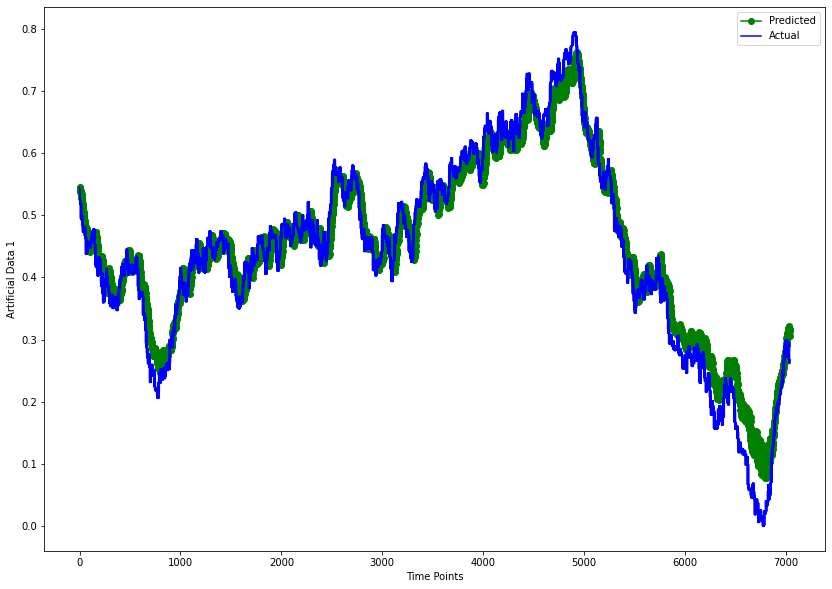

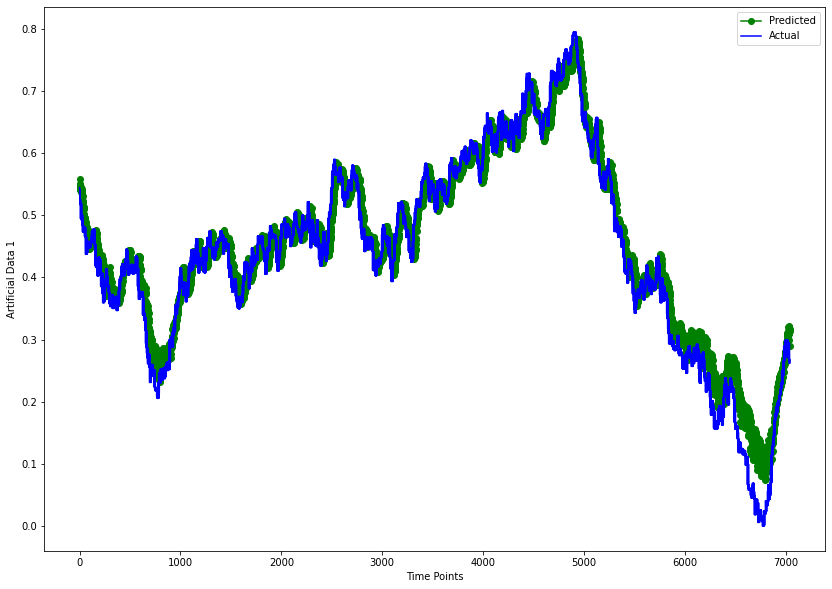

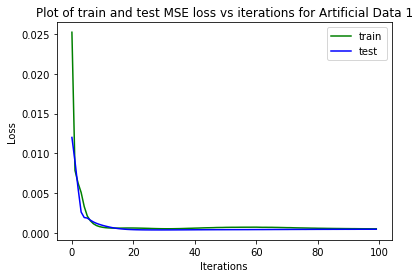

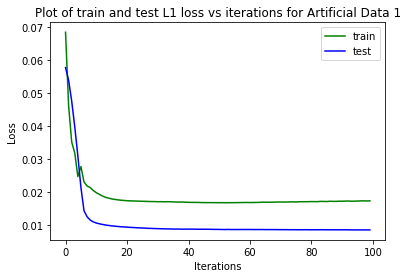

In [63]:
run_on_dataset(artificial1_df, 1, "Artificial Data 1", learning_rate)

# Artificial Dataset 2

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The MSE loss for train is: 0.009982110932469368
The MSE loss for test is: 0.009982110932469368
Iteration 1
********************
The MSE loss for train is: 0.008563056588172913
The MSE loss for test is: 0.008563056588172913
Iteration 2
********************
The MSE loss for train is: 0.009946058504283428
The MSE loss for test is: 0.009946058504283428
Iteration 3
********************
The MSE loss for train is: 0.01247774064540863
The MSE loss for test is: 0.01247774064540863
Iteration 4
********************
The MSE loss for train is: 0.012397457845509052
The MSE loss for test is: 0.012397457845509052
Iteration 5
********************
The MSE loss for train is: 0.007117013912647963
The MSE loss for test is: 0.007117013912647963
Iteration 6
********************
The MSE loss for train is: 0.0037475593853741884
The MSE loss for test is: 0.0037475593853741884
Iteration 7
********************
The MSE loss for train is: 0.0023341078776866198
The MSE loss for test 

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The L1 loss for train is: 0.15881593525409698
The L1 loss for test is: 0.15881593525409698
Iteration 1
********************
The L1 loss for train is: 0.08957863599061966
The L1 loss for test is: 0.08957863599061966
Iteration 2
********************
The L1 loss for train is: 0.11411681771278381
The L1 loss for test is: 0.11411681771278381
Iteration 3
********************
The L1 loss for train is: 0.10511689633131027
The L1 loss for test is: 0.10511689633131027
Iteration 4
********************
The L1 loss for train is: 0.03316611051559448
The L1 loss for test is: 0.03316611051559448
Iteration 5
********************
The L1 loss for train is: 0.0332924909889698
The L1 loss for test is: 0.0332924909889698
Iteration 6
********************
The L1 loss for train is: 0.02905764989554882
The L1 loss for test is: 0.02905764989554882
Iteration 7
********************
The L1 loss for train is: 0.029138702899217606
The L1 loss for test is: 0.029138702899217606
Iteratio

([0.009982110932469368,
  0.008563056588172913,
  0.009946058504283428,
  0.01247774064540863,
  0.012397457845509052,
  0.007117013912647963,
  0.0037475593853741884,
  0.0023341078776866198,
  0.0019107421394437551,
  0.0020200859289616346,
  0.0022369094658643007,
  0.0023497389629483223,
  0.0023517441004514694,
  0.002302852226421237,
  0.002223038347437978,
  0.002133855829015374,
  0.0020475557539612055,
  0.001963125541806221,
  0.001896919566206634,
  0.0018137504812330008,
  0.0017470744205638766,
  0.0016872106352820992,
  0.0016348250210285187,
  0.00156962510664016,
  0.0015217051841318607,
  0.0014663671609014273,
  0.0014153503580018878,
  0.0013795539271086454,
  0.0013397273141890764,
  0.0013009014073759317,
  0.0012711734743788838,
  0.0012490988010540605,
  0.0012200549244880676,
  0.0012028957717120647,
  0.001185196335427463,
  0.001169925439171493,
  0.0011636766139417887,
  0.001153821125626564,
  0.0011442763498052955,
  0.0011487029260024428,
  0.0011481718393

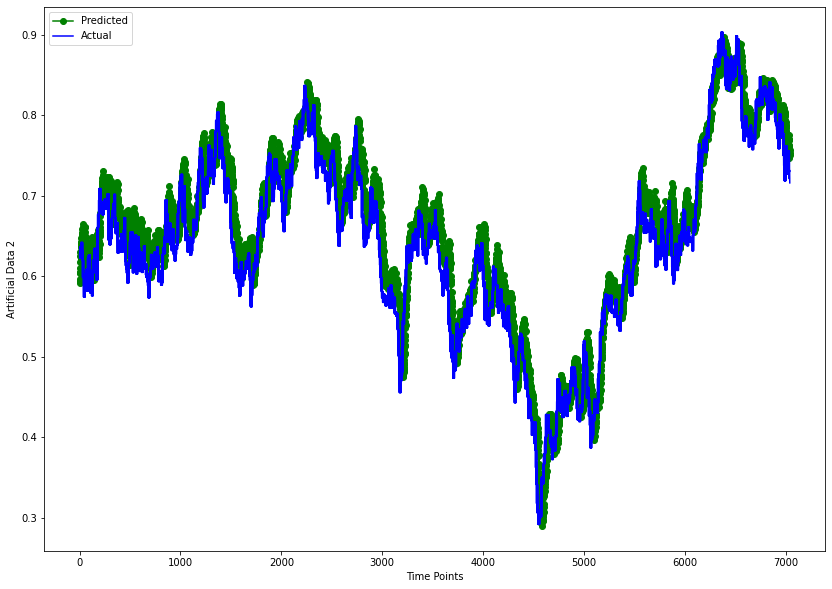

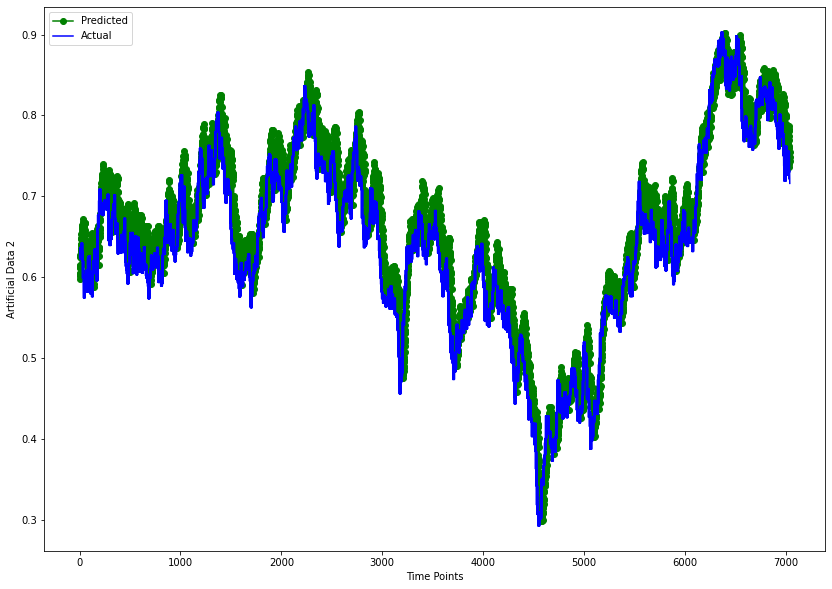

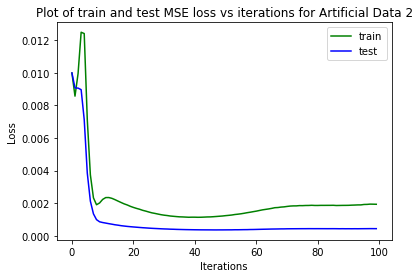

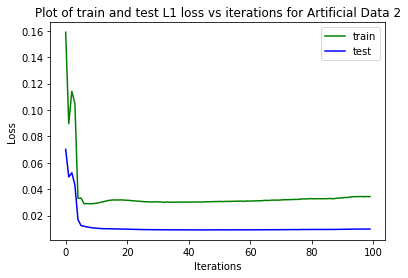

In [64]:
run_on_dataset(artificial2_df, 1, "Artificial Data 2", learning_rate)

# Microsoft Stock

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The MSE loss for train is: 0.2362922579050064
The MSE loss for test is: 0.2362922579050064
Iteration 1
********************
The MSE loss for train is: 0.16400481760501862
The MSE loss for test is: 0.16400481760501862
Iteration 2
********************
The MSE loss for train is: 0.11996136605739594
The MSE loss for test is: 0.11996136605739594
Iteration 3
********************
The MSE loss for train is: 0.09486471861600876
The MSE loss for test is: 0.09486471861600876
Iteration 4
********************
The MSE loss for train is: 0.08228683471679688
The MSE loss for test is: 0.08228683471679688
Iteration 5
********************
The MSE loss for train is: 0.07712701708078384
The MSE loss for test is: 0.07712701708078384
Iteration 6
********************
The MSE loss for train is: 0.0752723217010498
The MSE loss for test is: 0.0752723217010498
Iteration 7
********************
The MSE loss for train is: 0.07449422031641006
The MSE loss for test is: 0.07449422031641

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iteration 2
********************
The L1 loss for train is: 0.32108214497566223
The L1 loss for test is: 0.32108214497566223
Iteration 3
********************
The L1 loss for train is: 0.3132469356060028
The L1 loss for test is: 0.3132469356060028
Iteration 4
********************
The L1 loss for train is: 0.30878859758377075
The L1 loss for test is: 0.30878859758377075
Iteration 5
********************
The L1 loss for train is: 0.3041549324989319
The L1 loss for test is: 0.3041549324989319
Iteration 6
********************
The L1 loss for train is: 0.2987290620803833
The L1 loss for test is: 0.2987290620803833
Iteration 7
********************
The L1 loss for train is: 0.29251518845558167
The L1 loss for test is: 0.29251518845558167
Iteration 8
********************
The L1 loss for train is: 0.285088449716568
The L1 loss for test is: 0.285088449716568
Iteration 9
********************
The L1 loss for train is: 0.27613216638565063
The L1 loss for test is: 0.27613216638565063
Iteration 10
*****

([0.2362922579050064,
  0.16400481760501862,
  0.11996136605739594,
  0.09486471861600876,
  0.08228683471679688,
  0.07712701708078384,
  0.0752723217010498,
  0.07449422031641006,
  0.07388129085302353,
  0.07318177819252014,
  0.07236732542514801,
  0.0714026466012001,
  0.07034812867641449,
  0.06916534155607224,
  0.06784132868051529,
  0.06637467443943024,
  0.0647280290722847,
  0.0628882572054863,
  0.06082922965288162,
  0.05855251103639603,
  0.05603577569127083,
  0.05325010046362877,
  0.050218772143125534,
  0.04696746543049812,
  0.043495502322912216,
  0.039877910166978836,
  0.03618596866726875,
  0.03245921805500984,
  0.02884453907608986,
  0.025351807475090027,
  0.022132957354187965,
  0.019188540056347847,
  0.016583656892180443,
  0.014358555898070335,
  0.012493266724050045,
  0.010942213237285614,
  0.0096978098154068,
  0.008693460375070572,
  0.007897777482867241,
  0.007269476540386677,
  0.00674158800393343,
  0.0063210055232048035,
  0.005948367994278669,
 

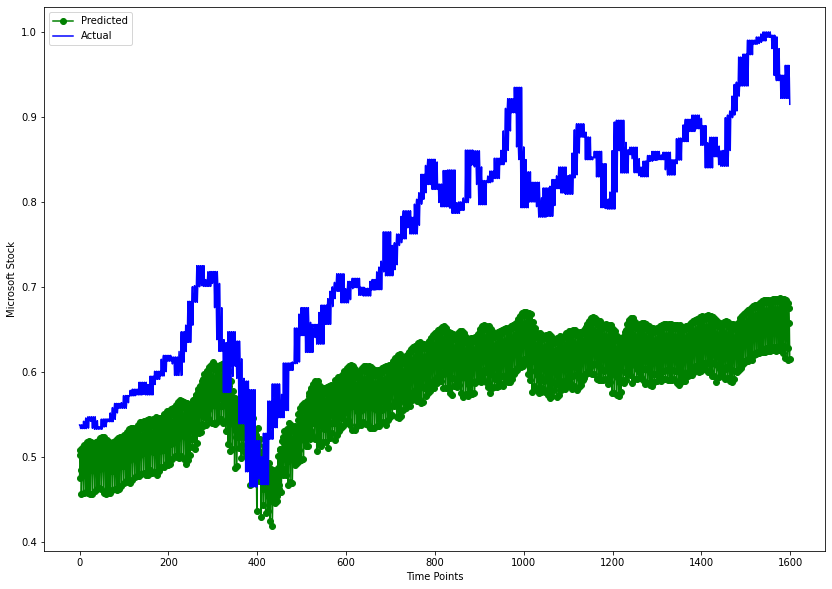

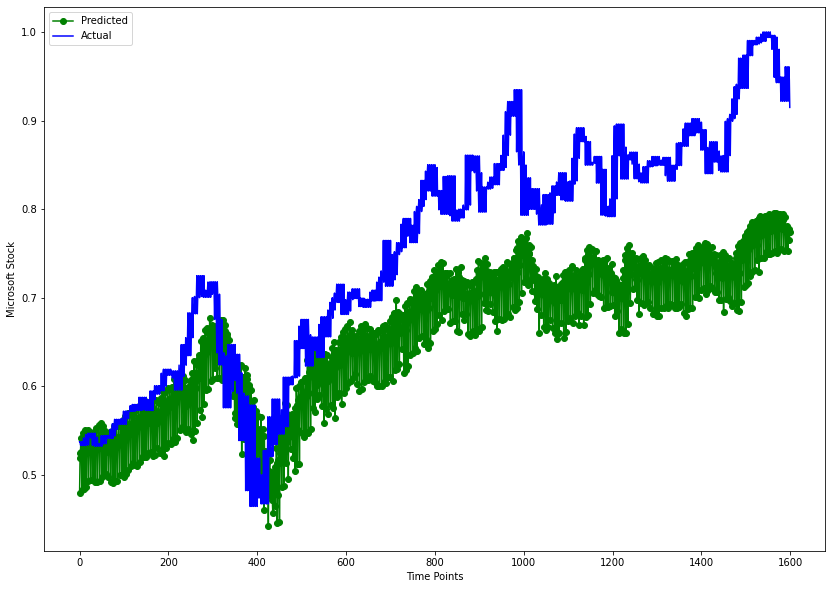

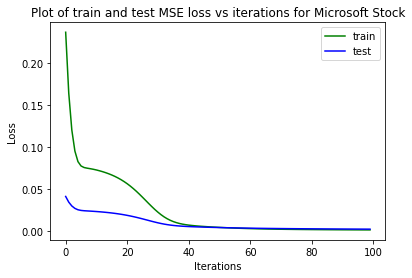

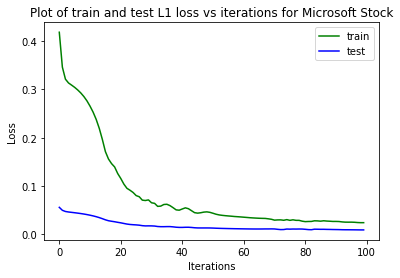

In [65]:
run_on_dataset(microsoft_df, 4, "Microsoft Stock", learning_rate)

# Crude Oil

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The MSE loss for train is: 0.1306525617837906
The MSE loss for test is: 0.1306525617837906
Iteration 1
********************
The MSE loss for train is: 0.040972985327243805
The MSE loss for test is: 0.040972985327243805
Iteration 2
********************
The MSE loss for train is: 0.012351167388260365
The MSE loss for test is: 0.012351167388260365
Iteration 3
********************
The MSE loss for train is: 0.01760977692902088
The MSE loss for test is: 0.01760977692902088
Iteration 4
********************
The MSE loss for train is: 0.030277160927653313
The MSE loss for test is: 0.030277160927653313
Iteration 5
********************
The MSE loss for train is: 0.03800399601459503
The MSE loss for test is: 0.03800399601459503
Iteration 6
********************
The MSE loss for train is: 0.04050722345709801
The MSE loss for test is: 0.04050722345709801
Iteration 7
********************
The MSE loss for train is: 0.040632136166095734
The MSE loss for test is: 0.04063

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iteration 1
********************
The L1 loss for train is: 0.29962509870529175
The L1 loss for test is: 0.29962509870529175
Iteration 2
********************
The L1 loss for train is: 0.262251079082489
The L1 loss for test is: 0.262251079082489
Iteration 3
********************
The L1 loss for train is: 0.20846156775951385
The L1 loss for test is: 0.20846156775951385
Iteration 4
********************
The L1 loss for train is: 0.15571370720863342
The L1 loss for test is: 0.15571370720863342
Iteration 5
********************
The L1 loss for train is: 0.177943155169487
The L1 loss for test is: 0.177943155169487
Iteration 6
********************
The L1 loss for train is: 0.1903621405363083
The L1 loss for test is: 0.1903621405363083
Iteration 7
********************
The L1 loss for train is: 0.1845523864030838
The L1 loss for test is: 0.1845523864030838
Iteration 8
********************
The L1 loss for train is: 0.17572282254695892
The L1 loss for test is: 0.17572282254695892
Iteration 9
********

([0.1306525617837906,
  0.040972985327243805,
  0.012351167388260365,
  0.01760977692902088,
  0.030277160927653313,
  0.03800399601459503,
  0.04050722345709801,
  0.040632136166095734,
  0.04015842825174332,
  0.03971202298998833,
  0.039369694888591766,
  0.03908910974860191,
  0.038842782378196716,
  0.03858575224876404,
  0.038325145840644836,
  0.03805918991565704,
  0.037769999355077744,
  0.037467893213033676,
  0.0371517539024353,
  0.03678106516599655,
  0.03640032559633255,
  0.03597123175859451,
  0.035491637885570526,
  0.03496019169688225,
  0.034360580146312714,
  0.03368722274899483,
  0.03292469307780266,
  0.03206845372915268,
  0.031097711995244026,
  0.029998932033777237,
  0.028781231492757797,
  0.027410605922341347,
  0.025893324986100197,
  0.024210769683122635,
  0.022389544174075127,
  0.020384229719638824,
  0.018264438956975937,
  0.016059886664152145,
  0.013874774798750877,
  0.011846709996461868,
  0.010103664360940456,
  0.008700761944055557,
  0.0076305

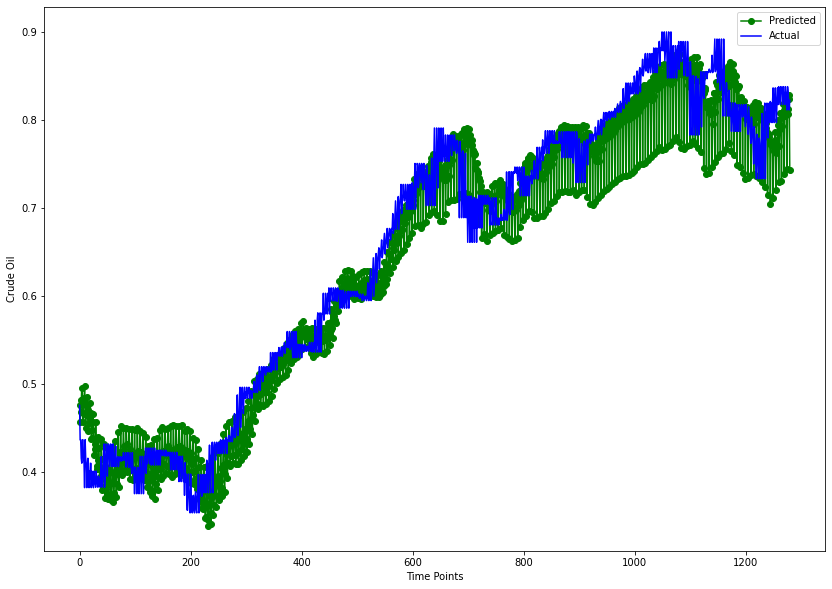

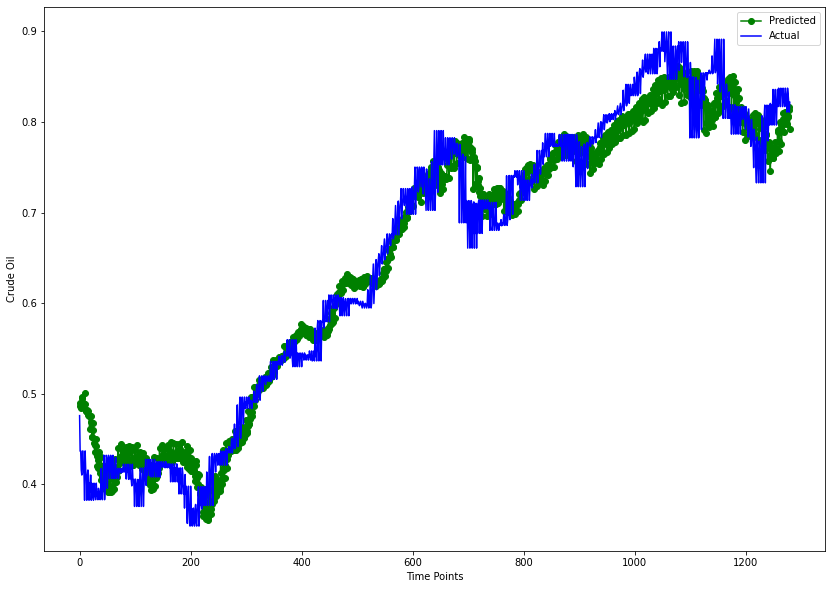

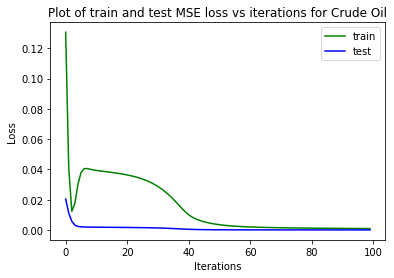

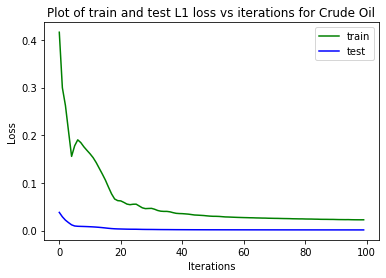

In [66]:
oil_df = oil_df[oil_df.DCOILBRENTEU != "."]
run_on_dataset(oil_df, 1, "Crude Oil", learning_rate)

# Bitcoin

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The MSE loss for train is: 0.008586768992245197
The MSE loss for test is: 0.008586768992245197
Iteration 1
********************
The MSE loss for train is: 0.009088554419577122
The MSE loss for test is: 0.009088554419577122
Iteration 2
********************
The MSE loss for train is: 0.009241334162652493
The MSE loss for test is: 0.009241334162652493
Iteration 3
********************
The MSE loss for train is: 0.008703273721039295
The MSE loss for test is: 0.008703273721039295
Iteration 4
********************
The MSE loss for train is: 0.00848065223544836
The MSE loss for test is: 0.00848065223544836
Iteration 5
********************
The MSE loss for train is: 0.008211812935769558
The MSE loss for test is: 0.008211812935769558
Iteration 6
********************
The MSE loss for train is: 0.007940702140331268
The MSE loss for test is: 0.007940702140331268
Iteration 7
********************
The MSE loss for train is: 0.007642908953130245
The MSE loss for test is:

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iteration 1
********************
The L1 loss for train is: 0.10131429135799408
The L1 loss for test is: 0.10131429135799408
Iteration 2
********************
The L1 loss for train is: 0.10350450873374939
The L1 loss for test is: 0.10350450873374939
Iteration 3
********************
The L1 loss for train is: 0.09961463510990143
The L1 loss for test is: 0.09961463510990143
Iteration 4
********************
The L1 loss for train is: 0.09960523247718811
The L1 loss for test is: 0.09960523247718811
Iteration 5
********************
The L1 loss for train is: 0.09938529133796692
The L1 loss for test is: 0.09938529133796692
Iteration 6
********************
The L1 loss for train is: 0.09748057276010513
The L1 loss for test is: 0.09748057276010513
Iteration 7
********************
The L1 loss for train is: 0.09514152258634567
The L1 loss for test is: 0.09514152258634567
Iteration 8
********************
The L1 loss for train is: 0.09442419558763504
The L1 loss for test is: 0.09442419558763504
Iteratio

([0.008586768992245197,
  0.009088554419577122,
  0.009241334162652493,
  0.008703273721039295,
  0.00848065223544836,
  0.008211812935769558,
  0.007940702140331268,
  0.007642908953130245,
  0.0072992583736777306,
  0.00690583698451519,
  0.0064415717497467995,
  0.005906054750084877,
  0.005295193754136562,
  0.00462817307561636,
  0.003921620547771454,
  0.0032100751996040344,
  0.002543272916227579,
  0.0019439822062849998,
  0.0014291992411017418,
  0.00099722552113235,
  0.000660615973174572,
  0.0004503027012106031,
  0.0003479429869912565,
  0.0002975270035676658,
  0.0002657988225109875,
  0.0002456789370626211,
  0.00023435006733052433,
  0.00022789346985518932,
  0.0002229062665719539,
  0.00022067432291805744,
  0.00021771910542156547,
  0.0002155449183192104,
  0.0002133203379344195,
  0.00021101912716403604,
  0.00020913056505378336,
  0.0002073077776003629,
  0.00020524446154013276,
  0.0002035438665188849,
  0.00020159002451691777,
  0.0002000157255679369,
  0.00019812

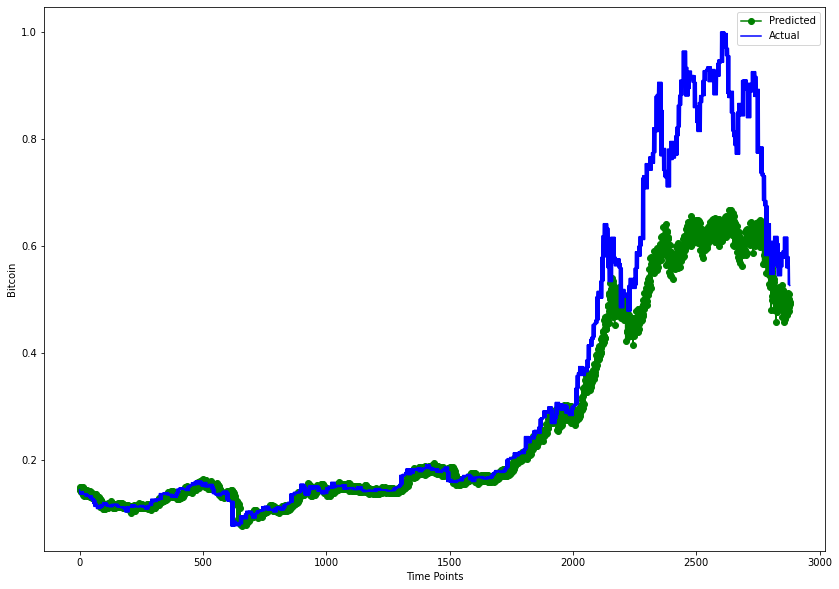

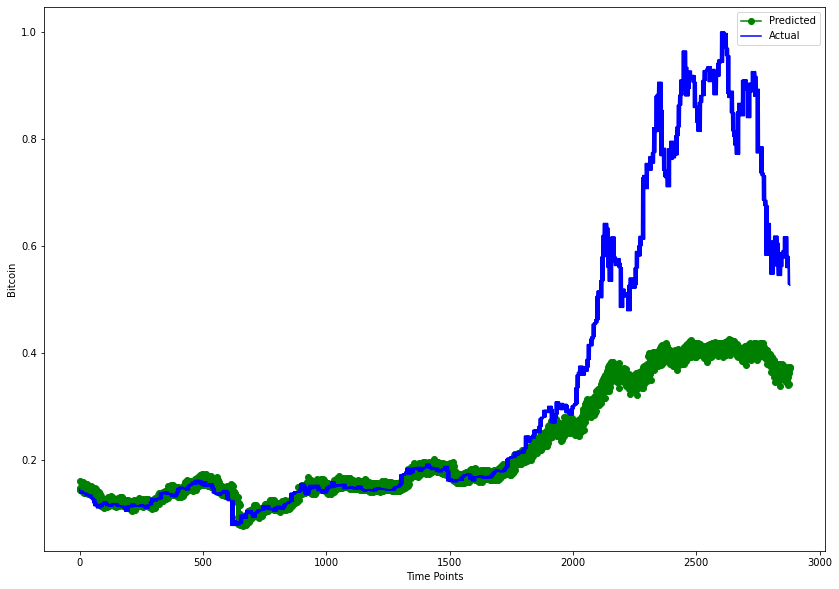

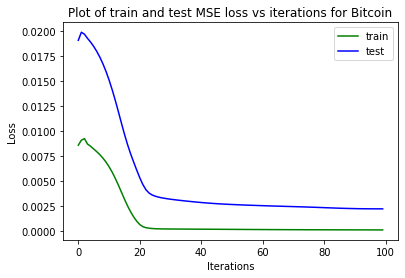

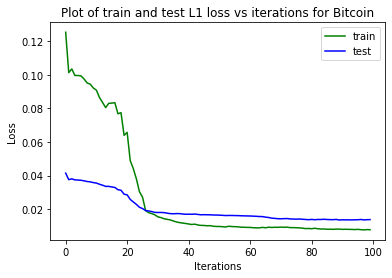

In [67]:
run_on_dataset(coin_df, 7, "Bitcoin", learning_rate)

# S&P 500

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The MSE loss for train is: 0.01679270528256893
The MSE loss for test is: 0.01679270528256893
Iteration 1
********************
The MSE loss for train is: 0.006842524744570255
The MSE loss for test is: 0.006842524744570255
Iteration 2
********************
The MSE loss for train is: 0.006887085270136595
The MSE loss for test is: 0.006887085270136595
Iteration 3
********************
The MSE loss for train is: 0.005758514162153006
The MSE loss for test is: 0.005758514162153006
Iteration 4
********************
The MSE loss for train is: 0.005547689739614725
The MSE loss for test is: 0.005547689739614725
Iteration 5
********************
The MSE loss for train is: 0.00531500019133091
The MSE loss for test is: 0.00531500019133091
Iteration 6
********************
The MSE loss for train is: 0.005169297568500042
The MSE loss for test is: 0.005169297568500042
Iteration 7
********************
The MSE loss for train is: 0.005055316723883152
The MSE loss for test is: 0

C:\Users\goodu\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:96: UserWarning: Using a target size (torch.Size([64, 5, 1])) that is different to the input size (torch.Size([64, 5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Iteration 0
********************
The L1 loss for train is: 0.10901959985494614
The L1 loss for test is: 0.10901959985494614
Iteration 1
********************
The L1 loss for train is: 0.09277208149433136
The L1 loss for test is: 0.09277208149433136
Iteration 2
********************
The L1 loss for train is: 0.0699666365981102
The L1 loss for test is: 0.0699666365981102
Iteration 3
********************
The L1 loss for train is: 0.06826189160346985
The L1 loss for test is: 0.06826189160346985
Iteration 4
********************
The L1 loss for train is: 0.06478693336248398
The L1 loss for test is: 0.06478693336248398
Iteration 5
********************
The L1 loss for train is: 0.06733431667089462
The L1 loss for test is: 0.06733431667089462
Iteration 6
********************
The L1 loss for train is: 0.06692997366189957
The L1 loss for test is: 0.06692997366189957
Iteration 7
********************
The L1 loss for train is: 0.07020734995603561
The L1 loss for test is: 0.07020734995603561
Iteration 

([0.01679270528256893,
  0.006842524744570255,
  0.006887085270136595,
  0.005758514162153006,
  0.005547689739614725,
  0.00531500019133091,
  0.005169297568500042,
  0.005055316723883152,
  0.004981608130037785,
  0.004938027821481228,
  0.004899072460830212,
  0.004876077175140381,
  0.004857351072132587,
  0.00483628548681736,
  0.004817086737602949,
  0.004804893862456083,
  0.004788386169821024,
  0.004768984392285347,
  0.004753141663968563,
  0.004738186486065388,
  0.004719295538961887,
  0.0047010513953864574,
  0.004681050311774015,
  0.004665206652134657,
  0.004642512183636427,
  0.004621672444045544,
  0.0046033356338739395,
  0.00457850843667984,
  0.004558234941214323,
  0.00453589390963316,
  0.004510160535573959,
  0.004483124241232872,
  0.004459715448319912,
  0.004430703353136778,
  0.004406224470585585,
  0.004375343676656485,
  0.004349872469902039,
  0.0043158456683158875,
  0.004288332536816597,
  0.004254879895597696,
  0.004220612812787294,
  0.00418498972430

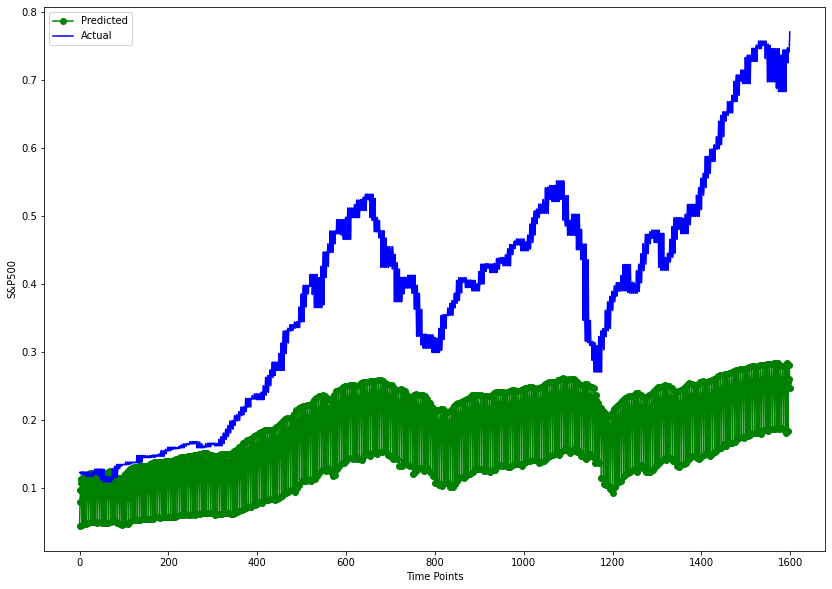

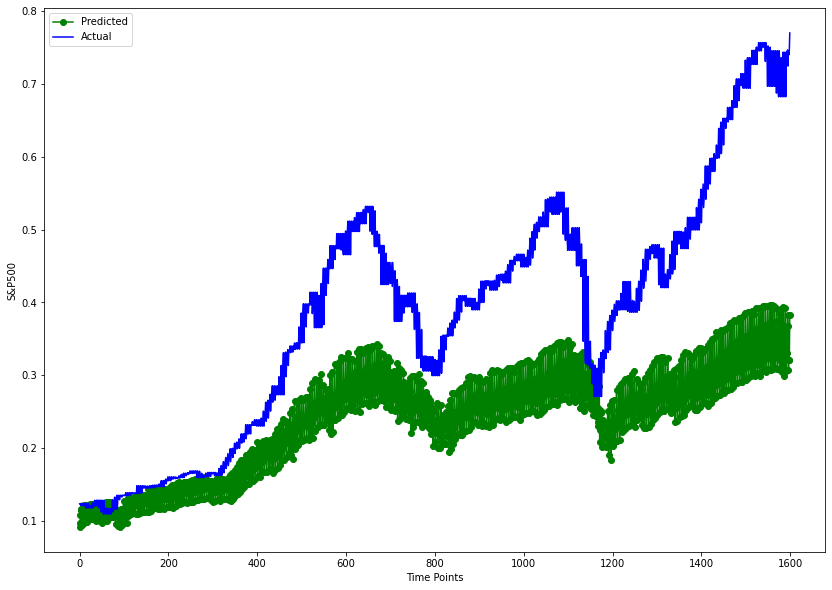

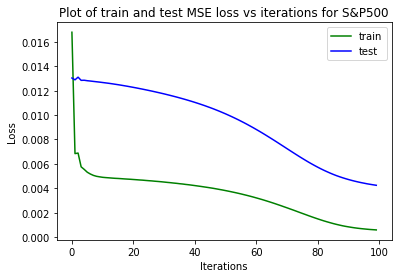

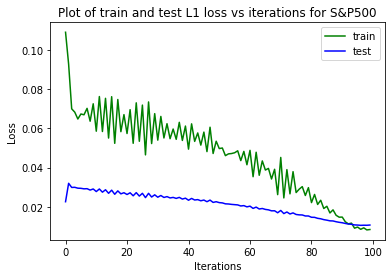

In [68]:
run_on_dataset(sp500_df, 1, "S&P500", learning_rate)